<a href="https://colab.research.google.com/github/FedericoSabbadini/RetiNeuraliGenerative/blob/main/lezione/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformers based Models: BERT and T5**

Authors: Nicola Arici (nicola.arici@unibs.it)

In this exercise we will see two Transformer based models: T5 and BERT <br/>
If you want to learn more about the models, try reading the articles: <br/>

1. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding <a href="https://arxiv.org/pdf/1810.04805.pdf">(2018, Devlin et al.)</a>
2. Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer <a href="https://arxiv.org/abs/1910.10683.pdf">(2019, Raffel et al.)</a>


The following notebook is divided in two main parts. In the first part we will see how implement a Text Classifier with BERT to solve many classification NLP tasks.<br>
In the second part we see how implementing T5 can improve the performance we obtain in the previous exercise over the translation ITA-ENG task.


## **Text Classification with BERT**

### **The Dataset**

In [50]:
!wget https://raw.githubusercontent.com/serivan/DeepLearning/master/Datasets/Tweets.csv -P ./data/

--2025-11-14 11:05:16--  https://raw.githubusercontent.com/serivan/DeepLearning/master/Datasets/Tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3501243 (3.3M) [text/plain]
Saving to: ‘./data/Tweets.csv.1’

Tweets.csv.1        100%[===================>]   3.34M  --.-KB/s    in 0.04s   

2025-11-14 11:05:16 (93.3 MB/s) - ‘./data/Tweets.csv.1’ saved [3501243/3501243]



In [51]:
import os
import torch
import random
import numpy as np
from transformers import logging
logging.set_verbosity_error()

SEED = 124564

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

In [52]:
import pandas as pd

df = pd.read_csv('data/Tweets.csv')
df.drop(['textID', 'selected_text'], axis=1, inplace=True)

df = df.drop_duplicates().dropna().reset_index(drop=True)
df = df.rename(columns={'sentiment': 'label'})

df

,text,label
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27475,wish we could come see u on Denver husband l...,negative
27476,I`ve wondered about rake to. The client has ...,negative
27477,Yay good for both of you. Enjoy the break - y...,positive
27478,But it was worth it ****.,positive


**Some statistics...**

MIN: 3
MEAN: 68.33002183406114
MAX: 141

QUANTILE
0.01     10.0
0.25     39.0
0.50     64.0
0.75     97.0
0.99    137.0
Name: text, dtype: float64


<Axes: >

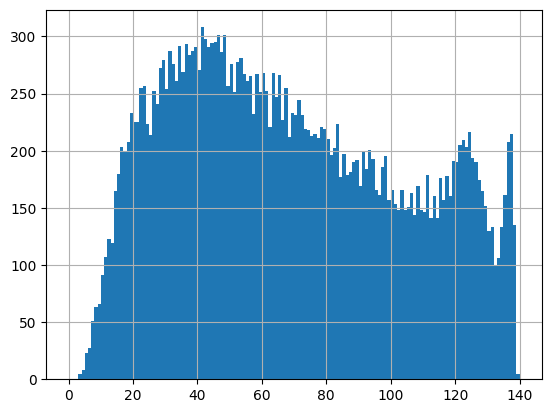

In [53]:
# Char length distribution.

lens = df.text.str.len()

print(f"MIN: {lens.min()}")
print(f"MEAN: {lens.mean()}")
print(f"MAX: {lens.max()}")


print("\nQUANTILE")
print(lens.quantile([0.01, 0.25, 0.5, 0.75, 0.99]))

lens.hist(bins = np.arange(0, max(lens), 1))

MIN: 1
MEAN: 12.90287481804949
MAX: 33

QUANTILE
0.01     2.0
0.25     7.0
0.50    12.0
0.75    18.0
0.99    28.0
Name: text, dtype: float64


<Axes: >

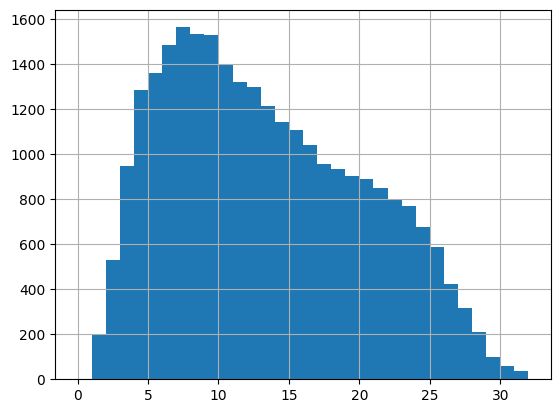

In [54]:
# Number of words distribution.

lens = df.text.str.split().map(lambda x: len(x))

print(f"MIN: {lens.min()}")
print(f"MEAN: {lens.mean()}")
print(f"MAX: {lens.max()}")


print("\nQUANTILE")
print(lens.quantile([0.01, 0.25, 0.5, 0.75, 0.99]))

lens.hist(bins = np.arange(0, max(lens), 1))

label
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


<Axes: >

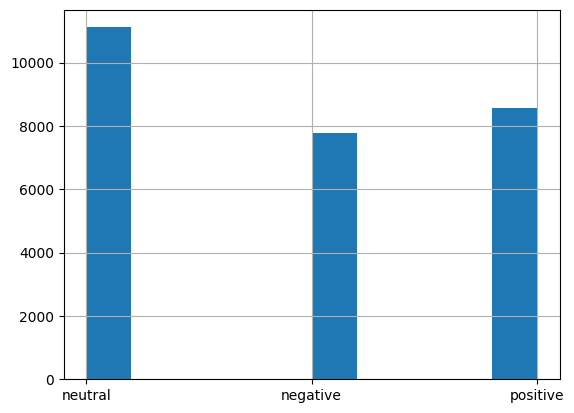

In [55]:
# Plot Labels distribution.

print(df.label.value_counts())

df.label.hist()

Let's build the PyTorch Dataset and Dataloader <br><br>

*Documentation:*

 - [HuggingFace Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)
 - [HuggingFace AutoTokenizer](https://huggingface.co/docs/transformers/v4.35.0/en/model_doc/auto#transformers.AutoTokenizer)
 - [HuggingFace BERT](https://huggingface.co/docs/transformers/model_doc/bert)
 - [HuggingFace bert-base-uncased](https://huggingface.co/bert-base-uncased)

In [56]:
LABEL_MAP = {"negative": 0, "neutral": 1, "positive": 2}
df['label'] = df['label'].map(LABEL_MAP)

In [57]:
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("bert-base-uncased")

tok("ciao come va", "tutto bene", padding="max_length", max_length=10)

{'input_ids': [101, 9915, 2080, 2272, 12436, 102, 10722, 9284, 3841, 2063, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [58]:
for t in [101, 9915, 2080, 2272, 12436, 102]:
    print(tok.decode(t))

[CLS]
cia
##o
come
va
[SEP]


In [59]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch


class SingleSentenceDataset(Dataset):

    def __init__(self, df, maxlen, bert):
        super(SingleSentenceDataset, self).__init__()

        self.df = df
        self.num_classes = len(self.df.label.unique())

        self.tokenizer = AutoTokenizer.from_pretrained(bert)
        self.maxlen = maxlen


    def __len__(self):
        return len(self.df)


    def __getitem__(self, index):
        sentence = str(self.df.loc[index, "text"])

        encoded = self.tokenizer(
            sentence,
            truncation=True,
            padding="max_length",
            max_length=self.maxlen,
            return_tensors='pt'
        )

        token_ids = encoded['input_ids'].squeeze(0)                 # (1, maxlen) -> (maxlen,)
        attn_mask = encoded['attention_mask'].squeeze(0)

        label = torch.zeros(self.num_classes)                 # [0, 0, 0]
        label[self.df.loc[index, "label"]] = 1                  # 2 -> [0, 0, 1]


        return token_ids, attn_mask, label

In [60]:
df_train = df.sample(frac=0.8, random_state=SEED).reset_index(drop=True)

df_test = df.drop(df_train.index).reset_index(drop=True)
df_val = df_test.sample(frac=0.5, random_state=SEED).reset_index(drop=True)

df_test = df_test.drop(df_val.index).reset_index(drop=True)


print(f"#Train examples: {len(df_train)}")
print(f"#Val   examples: {len(df_test)}")
print(f"#Test  examples: {len(df_val)}")

#Train examples: 21984
#Val   examples: 2748
#Test  examples: 2748


In [61]:
from torch.utils.data import DataLoader

BERT = "bert-base-uncased"
MAX_LEN = 40
BATCH_SIZE = 64

train_dataset = SingleSentenceDataset(df_train, MAX_LEN, BERT)
val_dataset = SingleSentenceDataset(df_val, MAX_LEN, BERT)
test_dataset = SingleSentenceDataset(df_test, MAX_LEN, BERT)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [62]:
for ids, att, l in train_loader:
    print(att.shape)
    print(l.shape)
    break

torch.Size([64, 40])
torch.Size([64, 3])


### The BERT Classifier

Finally, in this section we will start coding our PyTorch architecture.<br><br>


*Documentation:*

 - [PyTorch torch.nn](https://pytorch.org/docs/stable/nn.html)
 - [PyTorch torch.amp](https://docs.pytorch.org/docs/stable/amp.html)
 - [HuggingFace AutoModel](https://huggingface.co/docs/transformers/model_doc/auto)

In [63]:
from transformers import AutoModel

b = AutoModel.from_pretrained(BERT)
b

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [64]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score
from transformers import AutoModel
from torch import nn
from tqdm import tqdm
import copy


class Classifier(nn.Module):

    def __init__(self, bert, num_classes, dropout_rate, model_name, device):
        super(Classifier, self).__init__()

        self.model_name = model_name
        self.device = device

        self.llm_layer = AutoModel.from_pretrained(bert)
        self.dropout = nn.Dropout(dropout_rate)
        self.cls_layer = nn.Linear(self.llm_layer.config.hidden_size, num_classes)


    def forward(self, input_ids, attn_mask):

        lhs, pooler = self.llm_layer(input_ids, attn_mask, return_dict=False)

        # (bs, hs) --> (64, 768)
        sentence_representation = pooler

        # CLS grezzo
        #sentence_representation = lhs[:, 0, :]

        # mean lhs
        #sentence_representation = lhs.mean(dim=1)


        return self.cls_layer(self.dropout(sentence_representation))


    def train_architecture(self, train_data, val_data, epochs, criterion, optimizer, scaler):

        train_losses = []
        val_losses = []
        accuracies = []
        best_valloss = np.inf
        best_ep = 0
        best_model = copy.deepcopy(self.state_dict())

        for ep in tqdm(range(epochs)):
            self.train()
            ep_loss = 0.0

            for batch in train_data:
                optimizer.zero_grad()

                input_ids, attn_masks, labels = [b.to(self.device) for b in batch]

                with autocast('cuda'):
                    logits = self(input_ids, attn_masks)
                    loss = criterion(logits.squeeze(-1), labels.float())

                ep_loss += loss.item()

                # Backpropagation
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            train_losses.append(ep_loss/len(train_data))

            # Evaluation

            val_loss, accuracy = self.eval_model(val_data, criterion)
            accuracies.append(accuracy)
            val_losses.append(val_loss)

            if val_loss < best_valloss:
                best_valloss = val_loss
                best_model = copy.deepcopy(self.state_dict())
                best_ep = ep+1

        torch.save(best_model, f"models/{self.model_name}.pth")

        return train_losses, accuracies, val_losses, best_ep, best_valloss


    def eval_model(self, val_data, criterion):
        self.eval()

        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_data:
                input_ids, attn_masks, labels = [b.to(self.device) for b in batch]

                with autocast('cuda'):
                    logits = self(input_ids, attn_masks)
                    loss = criterion(logits.squeeze(-1), labels.float())
                    val_loss += loss.item()

                    val_preds.extend(logits.argmax(dim=-1).cpu().numpy())
                    val_labels.extend(labels.argmax(dim=-1).cpu().numpy())

        return val_loss/len(val_data), accuracy_score(val_labels, val_preds)


    def predict_data(self, test_data):
        self.eval()

        test_preds = []
        test_labels = []

        with torch.no_grad():
            for batch in tqdm(test_data, total=len(test_data)):
                input_ids, attn_masks, labels = [b.to(self.device) for b in batch]

                with autocast('cuda'):
                    logits = self(input_ids, attn_masks)

                test_preds += logits.argmax(dim=-1).cpu().numpy().tolist()
                test_labels += labels.argmax(dim=-1).cpu().numpy().tolist()

        return test_preds, test_labels



**Training**

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device loaded: {device}")

drop_rate = 0.25
lr = 2e-5
epochs = 5 # 10
weight_decay = 0.1

criterion = nn.BCEWithLogitsLoss()
scaler = GradScaler()

Device loaded: cuda


In [66]:
from torch.optim import AdamW
!mkdir -p models

model = Classifier(BERT, train_dataset.num_classes, drop_rate, "sentiment_classifier", device).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

print("Training the model...")
train_losses, accuracies, val_losses, best_ep, best_valloss = model.train_architecture(train_loader, val_loader, epochs, criterion, optimizer, scaler)

print(f"\n\nBest model at epoch {best_ep} with val loss {round(best_valloss, 4)}")

Training the model...


100%|██████████| 5/5 [04:10<00:00, 50.06s/it]




Best model at epoch 4 with val loss 0.1547


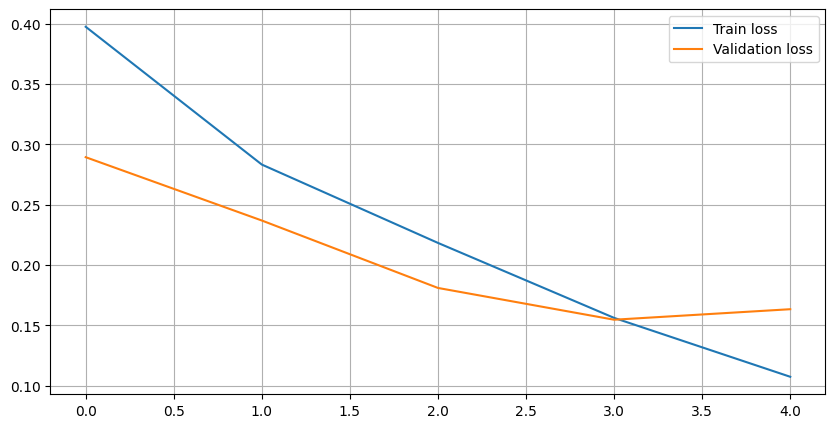

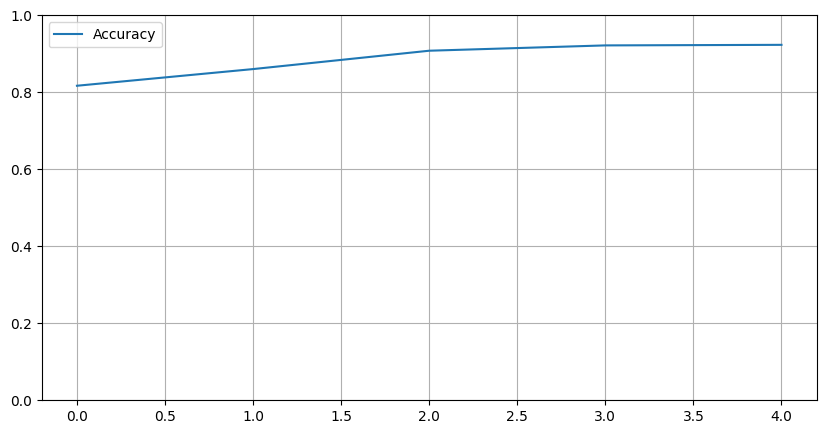

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

## Testing

*Documentation:* <br>

 - [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [70]:
from sklearn.metrics import classification_report


model.load_state_dict(torch.load(f"models/{model.model_name}.pth", weights_only=False))
test_preds, test_labels = model.predict_data(test_loader)

print()
print(classification_report(test_labels, test_preds, zero_division=0, target_names=LABEL_MAP.keys()))

100%|██████████| 43/43 [00:03<00:00, 12.31it/s]


              precision    recall  f1-score   support

    negative       0.93      0.94      0.93       794
     neutral       0.93      0.89      0.91      1167
    positive       0.89      0.95      0.92       787

    accuracy                           0.92      2748
   macro avg       0.92      0.92      0.92      2748
weighted avg       0.92      0.92      0.92      2748




BLEU (BiLingual Evaluation Understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is".

**BLEU's output is always a number between 0 and 1.** This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.


*Documentation:*

- [NLTK Implementation](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
- [EXTRA: SmoothingFunction](https://aclanthology.org/W14-3346.pdf)

In [69]:
from sklearn.metrics import accuracy_score

model.load_state_dict(torch.load(f"models/{model.model_name}.pth", weights_only=False))
test_preds, test_labels = model.predict_data(test_loader)

print(f"Test Accuracy for {model.model_name} model: {round(accuracy_score(test_labels, test_preds)*100, 2)}%")

100%|██████████| 43/43 [00:02<00:00, 18.54it/s]

Test Accuracy for sentiment_classifier model: 91.85%
